In [3]:
import pandas as pd
import numpy as np
import sklearn
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
import nltk.corpus
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

### 1.Predefined Functions for Later Use

In [4]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet


In [5]:
def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

def stem(txt):

    stemmer = PorterStemmer()
    stemReview = ''
    review = word_tokenize(txt)

    for i in review:
        i = stemmer.stem(i)
        stemReview = stemReview + ' ' + i
        #print(stemReview)
    return stemReview

In [6]:
def cleaning(intweet):
    cleanTweet = ''
    temptweet = word_tokenize(intweet)
    stopword = []
    for i in temptweet:
        #replace consecutive non-ASCII characters with a space
        i = re.sub(r'[^\x00-\x7F]+',' ',i)
        # remove digits
        i = re.sub(r'\d+', '', i)
        # remove html tags
        i = re.sub('(?:<[^>]+>)', '',i)
        #remove more than one space
        i = re.sub(r"\s+","", i)
        i = re.sub(r"[,@\"'?\.$%_]", "", i, flags=re.I)
        # lower case first letter and keep all uppercase word
        if i.isupper():
            i = i
        else:
            i = i.lower()
        stopword = stopwords.words('english')
        Extra = ['"',"\"","n't","'s","...","!","?","I","@USER","USER","URL",".",";",":","/","\\",",","#","@","$","&",")","(","\""]
        yesnowords = ["can", "could", "would", "is", "does", "has", "was", "were", "had", "have", "did", "are", "will"]
        commonwords = ["the", "a", "an", "is", "are", "were", "."]
        questionwords = ["who", "what", "where", "when", "why", "how", "whose", "which", "whom"]
        # https://github.com/debjyoti385/QuestionAnswerNLP/blob/master/qa.py
        pronouns = ["he", "she", "it", "its", "it's", "him", "her", "his","they","their","we", "our","i","you","your","my","mine","yours","ours","all", "", "he", "her", "hers", "herself", "him", "himself", "his", "", "", "it", "its", "itself", "many", "me mine", "more", "most", "much", "my", "myself", "neither", "no one", "nobody", "none", "nothing", "one", "other", "others", "our", "ours", "ourselves", "several", "she", "some", "somebody", "someone", "something", "that", "their", "theirs", "them", "themselves", "these", "they", "this", "those", "us", "we", "which",  "who", "whoever", "whom", "whose", "you", "your", "yours", "yourself", "yourselves"]
        stopword = stopword + Extra + yesnowords + commonwords + questionwords + pronouns
        if i not in stopword:
            cleanTweet = cleanTweet + ' ' + i 
            #print(cleanReview)
    return cleanTweet

### 2.Read Data

In [8]:
df = pd.read_csv('olidtrain.csv')

In [9]:
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [10]:
len(df)

13240

### 3.Data Exploration

#### 3.1 Bar Chart of Number of Offensive and Not Offensive tweets

In [11]:
# create a new column with a full name of a classe.
df['target_name'] = df['subtask_a'].map({'NOT': 'Not Offensive', 'OFF': 'Offensive'})

Text(0.5,1,'Not Offensive VS Offensive')

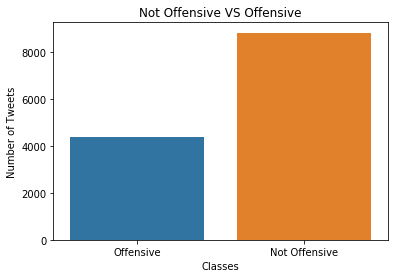

In [12]:
sns.countplot(df.target_name)
plt.xlabel('Classes');
plt.ylabel('Number of Tweets')
plt.title('Not Offensive VS Offensive')

#### 3.2 Checking if there is any retweet

In [13]:
# Make a new column to highlight retweets
df['is_retweet'] = df['tweet'].apply(lambda x: r'[r|R][t|T]' in x[:3])
print ("Total number of retweet is " + str(sum(df['is_retweet']))+ '.')
#df['is_retweet'].value_counts()

Total number of retweet is 0.


#### 3.3 Cleaning the tweet

In [14]:
# Cleaning the tweet by applying pre-defined cleaning()
df['clean_Tweet'] = [cleaning(tweet) for tweet in df['tweet']]
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c,target_name,is_retweet,clean_Tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,Offensive,False,ask native americans take
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,Offensive,False,go home drunk MAGA trump
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,Not Offensive,False,amazon investigating chinese employees sellin...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,Offensive,False,shouldvetaken piece shit volcano
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,Not Offensive,False,obama wanted liberals amp illegals move red s...


In [15]:
# Stemming the tweet
df['stem_Tweet'] = [stem(tweet) for tweet in df['clean_Tweet']]
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c,target_name,is_retweet,clean_Tweet,stem_Tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,Offensive,False,ask native americans take,ask nativ american take
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,Offensive,False,go home drunk MAGA trump,go home drunk maga trump
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,Not Offensive,False,amazon investigating chinese employees sellin...,amazon investig chines employe sell intern da...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,Offensive,False,shouldvetaken piece shit volcano,shouldvetaken piec shit volcano
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,Not Offensive,False,obama wanted liberals amp illegals move red s...,obama want liber amp illeg move red state


#### 3.4 Applying Word Tokenizer

In [26]:
tt = TweetTokenizer()
df['tokenized']= df['clean_Tweet'].apply(tt.tokenize)
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c,target_name,is_retweet,clean_Tweet,stem_Tweet,tokenized
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,Offensive,False,ask native americans take,ask nativ american take,"[ask, native, americans, take]"
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,Offensive,False,go home drunk MAGA trump,go home drunk maga trump,"[go, home, drunk, MAGA, trump]"
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,Not Offensive,False,amazon investigating chinese employees sellin...,amazon investig chines employe sell intern da...,"[amazon, investigating, chinese, employees, se..."
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,Offensive,False,shouldvetaken piece shit volcano,shouldvetaken piec shit volcano,"[shouldvetaken, piece, shit, volcano]"
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,Not Offensive,False,obama wanted liberals amp illegals move red s...,obama want liber amp illeg move red state,"[obama, wanted, liberals, amp, illegals, move,..."


#### 3.5 Frequency Distribution of the tweet

In [27]:
# Below is the one way of getting counts of each word
Counter(" ".join(df["stem_Tweet"]).lower().split()).most_common(30)

[('liber', 1634),
 ('gun', 1528),
 ('nt', 1315),
 ('control', 1246),
 ('like', 1195),
 ('antifa', 1170),
 ('conserv', 1067),
 ('maga', 1037),
 ('peopl', 931),
 ('get', 906),
 ('go', 744),
 ('know', 742),
 ('trump', 701),
 ('think', 686),
 ('amp', 677),
 ('say', 615),
 ('right', 568),
 ('want', 561),
 ('need', 538),
 ('make', 530),
 ('good', 469),
 ('time', 465),
 ('look', 450),
 ('love', 410),
 ('democrat', 409),
 ('see', 409),
 ('-', 408),
 ('vote', 398),
 ('tri', 392),
 ('support', 385)]

In [28]:
# another way of getting counts by using FreqDist()
fdist = FreqDist(" ".join(df["stem_Tweet"]).lower().split())
most_common = fdist.most_common(25)
most_common

[('liber', 1634),
 ('gun', 1528),
 ('nt', 1315),
 ('control', 1246),
 ('like', 1195),
 ('antifa', 1170),
 ('conserv', 1067),
 ('maga', 1037),
 ('peopl', 931),
 ('get', 906),
 ('go', 744),
 ('know', 742),
 ('trump', 701),
 ('think', 686),
 ('amp', 677),
 ('say', 615),
 ('right', 568),
 ('want', 561),
 ('need', 538),
 ('make', 530),
 ('good', 469),
 ('time', 465),
 ('look', 450),
 ('love', 410),
 ('democrat', 409)]

In [30]:
# make the data frame 
freq = pd.DataFrame(most_common, columns=['words', 'count'])
freq.head()

,words,count
0,liber,1634
1,gun,1528
2,nt,1315
3,control,1246
4,like,1195


In [32]:
# function for producing the line chart for most common 25 words of tweets
def freq_plot(tweet_series):
    fdist = FreqDist(" ".join(tweet_series).lower().split())
    most_common = fdist.most_common(30)
    print(most_common)
    freq = pd.DataFrame(most_common, columns=['words', 'count'])
    fig = plt.figure()
    ax = plt.axes()
    col_vec = freq['count'][:, np.newaxis]
    ax.plot(freq.words, col_vec)
    plt.xticks(rotation=90)
    plt.xlabel('Word',color = 'orange')
    plt.ylabel('Count',color = 'orange')
    plt.title('Most Common 25 Words',color='orange')


[('liber', 1634), ('gun', 1528), ('nt', 1315), ('control', 1246), ('like', 1195), ('antifa', 1170), ('conserv', 1067), ('maga', 1037), ('peopl', 931), ('get', 906), ('go', 744), ('know', 742), ('trump', 701), ('think', 686), ('amp', 677), ('say', 615), ('right', 568), ('want', 561), ('need', 538), ('make', 530), ('good', 469), ('time', 465), ('look', 450), ('love', 410), ('democrat', 409), ('see', 409), ('-', 408), ('vote', 398), ('tri', 392), ('support', 385)]


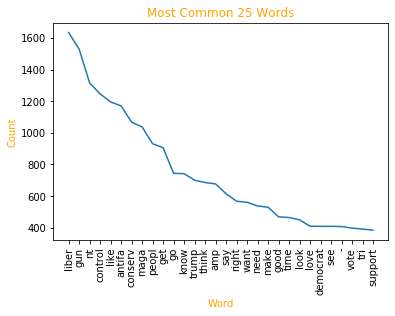

In [33]:
# frequency distribution plot of most common words for overall tweets not regarding to classes
freq_plot(df["stem_Tweet"])

[('liber', 640), ('gun', 563), ('like', 507), ('control', 461), ('nt', 454), ('peopl', 383), ('get', 336), ('shit', 332), ('fuck', 327), ('antifa', 316), ('go', 308), ('maga', 305), ('conserv', 287), ('amp', 279), ('know', 277), ('trump', 274), ('think', 251), ('say', 226), ('want', 195), ('make', 193), ('democrat', 190), ('need', 184), ('right', 179), ('lie', 167), ('ass', 161), ('time', 158), ('tri', 156), ('good', 152), ('look', 150), ('even', 141)]


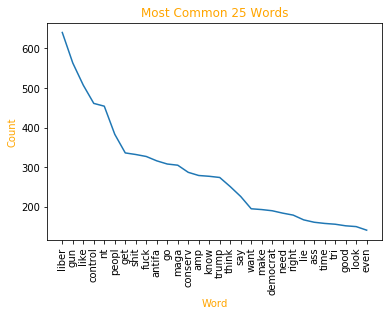

In [34]:
# frequency plot of most common words for Offensive tweets
freq_plot(df[df['target_name'] == 'Offensive']['stem_Tweet'])

[('liber', 994), ('gun', 965), ('nt', 861), ('antifa', 854), ('control', 785), ('conserv', 780), ('maga', 732), ('like', 688), ('get', 570), ('peopl', 548), ('know', 465), ('go', 436), ('think', 435), ('trump', 427), ('amp', 398), ('right', 389), ('say', 389), ('want', 366), ('need', 354), ('make', 337), ('good', 317), ('love', 316), ('time', 307), ('-', 306), ('look', 300), ('vote', 283), ('see', 274), ('support', 262), ('thank', 262), ('work', 252)]


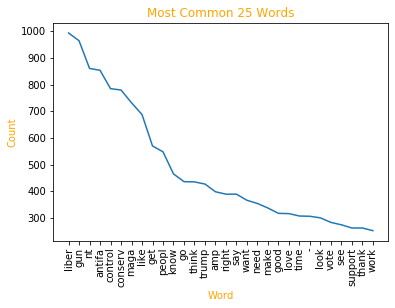

In [35]:
# frequency plot of most common words for Not Offensive tweets
freq_plot(df[df['target_name'] == 'Not Offensive']['stem_Tweet'])

#### 3.6 Bar Chart of Most Common Words for both classes (in common)

In [16]:
# hard coded the value from above result, could have been done in better ways
off = [('liber', 640), ('gun', 563), ('like', 507), ('control', 461), ('nt', 454), ('peopl', 383), ('get', 336), ('shit', 332), ('fuck', 327), ('antifa', 316), ('go', 308), ('maga', 305), ('conserv', 287), ('amp', 279), ('know', 277), ('trump', 274), ('think', 251), ('say', 226), ('want', 195), ('make', 193), ('democrat', 190), ('need', 184), ('right', 179), ('lie', 166), ('ass', 161), ('time', 158), ('tri', 156), ('good', 152), ('look', 150), ('even', 141)]
noff = [('liber', 994), ('gun', 965), ('nt', 861), ('antifa', 854), ('control', 785), ('conserv', 780), ('maga', 732), ('like', 688), ('get', 570), ('peopl', 548), ('know', 465), ('go', 436), ('think', 435), ('trump', 427), ('amp', 398), ('right', 389), ('say', 389), ('want', 366), ('need', 354), ('make', 337), ('good', 317), ('love', 316), ('time', 307), ('-', 306), ('look', 300)]
df_off = pd.DataFrame(off, columns=['words', 'count'])
df_noff = pd.DataFrame(noff, columns=['words', 'count'])

In [17]:
# find out the intersaction of most common words
df_most_count = pd.merge(df_off,df_noff,on='words',how='inner')
df_most_count # count_x is offensive; count_y is not offensive

,words,count_x,count_y
0,liber,640,994
1,gun,563,965
2,like,507,688
3,control,461,785
4,nt,454,861
5,peopl,383,548
6,get,336,570
7,antifa,316,854
8,go,308,436
9,maga,305,732


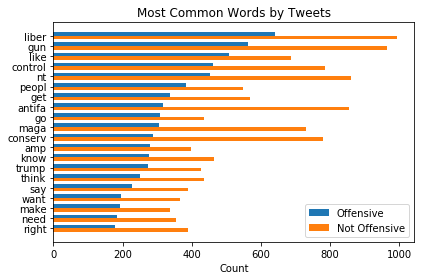

In [18]:
labels = ' '.join(df_most_count['words']).split() # make the words as a list 
labels = labels[0:20]
count_x = df_most_count['count_x'][0:20]
count_y = df_most_count['count_y'][0:20]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(x - width/2, count_x, width, label='Offensive')
rects2 = ax.barh(x + width/2, count_y, width, label='Not Offensive')

ax.set_xlabel('Count')
ax.set_title('Most Common Words by Tweets')
ax.set_yticks(x)

ax.set_yticklabels(labels)
ax.legend()
ax.invert_yaxis()

fig.tight_layout()
plt.show()

######  Another way of showing it by applying Stacked Bar Chart

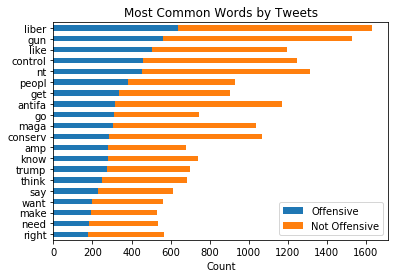

In [39]:
labels = ' '.join(df_most_count['words']).split() # make the words as a list 
labels = labels[0:20]
ax = df_most_count[0:20].plot(kind='barh', stacked=True)
ax.set_yticklabels(labels)
ax.set_xlabel('Count')
ax.set_title('Most Common Words by Tweets')
ax.set_yticks(x)
ax.invert_yaxis()
x = np.arange(len(labels))
ax.legend(['Offensive','Not Offensive'])

#### 3.7 Word Cloud for Most Common Words

In [20]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [21]:
def show_wordcloud(text):    
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 40, # max_words controls number of words appear in the word cloud
        max_font_size = 60, 
        scale = 3,
        random_state = 1 
    ).generate(str(text))

    plt.figure(1, figsize = (12, 12))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()  

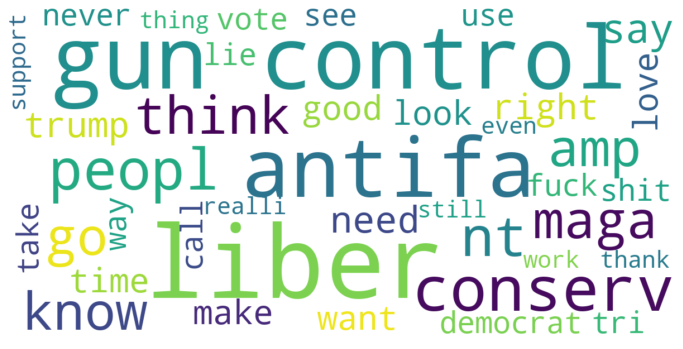

In [74]:
show_wordcloud(" ".join(df['stem_Tweet']).lower())

#### 3.8 Bar Chart for Most Common Hashtags

In [22]:
df['mentioned'] = df.tweet.apply(find_mentioned)
df['hashtags'] = df.tweet.apply(find_hashtags)

In [23]:
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c,target_name,is_retweet,clean_Tweet,stem_Tweet,mentioned,hashtags
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,Offensive,False,ask native americans take,ask nativ american take,[@USER],[]
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,Offensive,False,go home drunk MAGA trump,go home drunk maga trump,"[@USER, @USER, @USER]","[#MAGA, #Trump2020]"
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,Not Offensive,False,amazon investigating chinese employees sellin...,amazon investig chines employe sell intern da...,[],"[#Amazon, #MAGA, #KAG, #CHINA, #TCOT]"
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,Offensive,False,shouldvetaken piece shit volcano,shouldvetaken piec shit volcano,[@USER],[]
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,Not Offensive,False,obama wanted liberals amp illegals move red s...,obama want liber amp illeg move red state,"[@USER, @USER]",[]


In [24]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = df.loc[df.hashtags.apply(lambda hashtags_list: hashtags_list !=[]),['hashtags']]
print('Total # of tweets containing hashtags is: ' + str(len(hashtags_list_df)) + '.')
hashtags_list_df.head()

Total # of tweets containing hashtags is: 1898.


,hashtags
1,"[#MAGA, #Trump2020]"
2,"[#Amazon, #MAGA, #KAG, #CHINA, #TCOT]"
9,"[#LooneyLeft, #Liberals, #Qproofs, #TrudeauMus..."
11,"[#Kavanaugh, #confirmed, #DemsareFrauds, #Dems..."
12,[#DeepStateCorruption]


In [25]:
# create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
print(len(flattened_hashtags_df))
flattened_hashtags_df.head()

5282


,hashtag
0,#MAGA
1,#Trump2020
2,#Amazon
3,#MAGA
4,#KAG


In [26]:
# since some hashtags are same but cases
# so make all hashtags lowercase and then add '#' back to the strings
flattened_hashtags_df['lower_case'] = list(map(lambda hashtag:hashtag.split('#')[1].lower() , flattened_hashtags_df['hashtag'])) 
flattened_hashtags_df['lower_hashtag'] = list(map(lambda x: '#'+(x),flattened_hashtags_df['lower_case']))
flattened_hashtags_df.head()

,hashtag,lower_case,lower_hashtag
0,#MAGA,maga,#maga
1,#Trump2020,trump2020,#trump2020
2,#Amazon,amazon,#amazon
3,#MAGA,maga,#maga
4,#KAG,kag,#kag


In [27]:
# just for testing
# find out all hashtags that contain 'maga'
flattened_hashtags_df[flattened_hashtags_df['lower_case'].str.contains('maga')]['lower_case'].value_counts()

maga              824
maga2020            6
maga2kag            5
magats              2
magarallyrules      2
magaforallinc       2
obamagate           2
maga2018            2
magaveterans        1
magadingdong        1
kravmaga            1
maga-               1
magatalk            1
magabots            1
ljmaga              1
Name: lower_case, dtype: int64

In [28]:
# number of unique hashtags
uniHash = flattened_hashtags_df['lower_hashtag'].unique().size
print('Number of unique hashtags is', str(uniHash) + '.')

Number of unique hashtags is 2118.


In [29]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('lower_hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
popular_hashtags.head(15)

,lower_hashtag,counts
0,#maga,824
1,#conservatives,97
2,#antifa,87
3,#qanon,84
4,#walkaway,80
5,#wwg1wga,76
6,#kag,72
7,#tcot,57
8,#trump,56
9,#kavanaugh,53


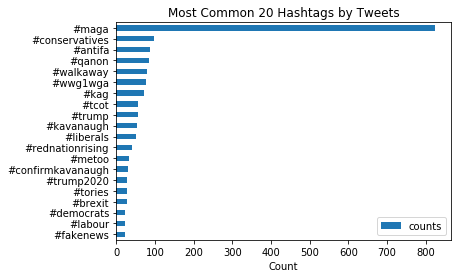

In [30]:
labels = ' '.join(popular_hashtags['lower_hashtag']).split() # make the words as a list 
labels = labels[0:20]
x = np.arange(len(labels))
ax = popular_hashtags[0:20].plot(kind='barh', stacked=True)
ax.set_yticklabels(labels)
ax.set_xlabel('Count')
ax.set_title('Most Common 20 Hashtags by Tweets')
ax.set_yticks(x)
ax.invert_yaxis()
plt.savefig('hashtag.png')

#### 3.9 Word Cloud for Hashtags

##### 3.9.1

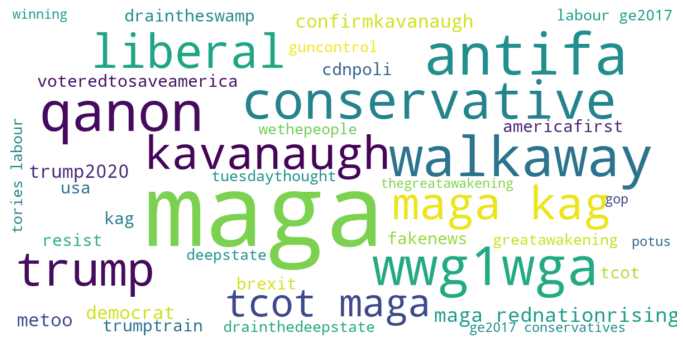

In [84]:
wordcloud_hashtag = show_wordcloud(" ".join(flattened_hashtags_df['lower_hashtag']))
wordcloud_hashtag

##### 3.9.2 Twitter Mask Word Cloud for Hashtags

/Users/derichong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/derichong/anaconda3/lib/python3.7/site-packages/wordcloud/wordcloud.py:721: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"
/Users/derichong/anaconda3/lib/python3.7/site-packages/wordcloud/wordcloud.py:721: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


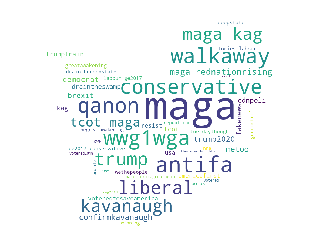

In [32]:
from scipy.misc import imread
# The twitter mask is in Visualization folder
twitter_mask = imread('Visualization/twitter_mask.png', flatten=True)

wordcloud = WordCloud(
                      background_color='white',
                     # width=1800,
                      #height=1400,
                      max_words=50,
                      mask=twitter_mask
            ).generate(" ".join(flattened_hashtags_df['lower_case']))

plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./my_twitter_wordcloud.png', dpi=300)
plt.show()

#### 3.10 Co-occurance and Networking Analysis

In [86]:
tweets = list(df["clean_Tweet"])

In [113]:
tweets[0:20]

[' ask native americans take',
 ' go home drunk MAGA trump',
 ' amazon investigating chinese employees selling internal data third-party sellers looking edge competitive marketplace amazon MAGA KAG CHINA TCOT',
 ' shouldvetaken piece shit volcano',
 ' obama wanted liberals amp illegals move red states',
 ' liberals kookoo',
 ' oh noes tough shit',
 ' literally talking lol mass shootings like set ups propaganda used divide major issues like gun control terrorism',
 ' buy icecream',
 ' canada need another CUCK already enough looneyleft liberals f**king great country qproofs trudeaumustgo',
 ' fault support gun control',
 ' difference kavanaugh men admitted groping year old girl years ago going confirmed SCJ demsarefrauds demsaredone walkawaydemocrats redwave voteredsaveamerica trumptrain MAGA',
 ' lying corrupt traitor wants hear anymore lies deepstatecorruption',
 ' scare every american playing hockey warped puck',
 ' like soda like like boarders lot ICE',
 ' also king taste',
 ' MAGA s

In [114]:
tweet_nostrip = [x.strip() for x in tweets]
tweet_nostrip[0:10]

['ask native americans take',
 'go home drunk MAGA trump',
 'amazon investigating chinese employees selling internal data third-party sellers looking edge competitive marketplace amazon MAGA KAG CHINA TCOT',
 'shouldvetaken piece shit volcano',
 'obama wanted liberals amp illegals move red states',
 'liberals kookoo',
 'oh noes tough shit',
 'literally talking lol mass shootings like set ups propaganda used divide major issues like gun control terrorism',
 'buy icecream',
 'canada need another CUCK already enough looneyleft liberals f**king great country qproofs trudeaumustgo']

In [128]:
len(tweet_nostrip)

13240

In [115]:
from nltk import ngrams

##### 3.10.1 Bigram

In [129]:
# Tokenize each tweet
bigram =[]
for line in tweet_nostrip:
    token = nltk.word_tokenize(line)
    bigram.append(list(ngrams(token, 2)))


In [130]:
bigram[0:20]

[[('ask', 'native'), ('native', 'americans'), ('americans', 'take')],
 [('go', 'home'), ('home', 'drunk'), ('drunk', 'MAGA'), ('MAGA', 'trump')],
 [('amazon', 'investigating'),
  ('investigating', 'chinese'),
  ('chinese', 'employees'),
  ('employees', 'selling'),
  ('selling', 'internal'),
  ('internal', 'data'),
  ('data', 'third-party'),
  ('third-party', 'sellers'),
  ('sellers', 'looking'),
  ('looking', 'edge'),
  ('edge', 'competitive'),
  ('competitive', 'marketplace'),
  ('marketplace', 'amazon'),
  ('amazon', 'MAGA'),
  ('MAGA', 'KAG'),
  ('KAG', 'CHINA'),
  ('CHINA', 'TCOT')],
 [('shouldvetaken', 'piece'), ('piece', 'shit'), ('shit', 'volcano')],
 [('obama', 'wanted'),
  ('wanted', 'liberals'),
  ('liberals', 'amp'),
  ('amp', 'illegals'),
  ('illegals', 'move'),
  ('move', 'red'),
  ('red', 'states')],
 [('liberals', 'kookoo')],
 [('oh', 'noes'), ('noes', 'tough'), ('tough', 'shit')],
 [('literally', 'talking'),
  ('talking', 'lol'),
  ('lol', 'mass'),
  ('mass', 'shootings

In [140]:
# flatten the list
flat_bigram_list = [item for sublist in bigram for item in sublist ]
flat_bigram_list[0:5]

[('ask', 'native'),
 ('native', 'americans'),
 ('americans', 'take'),
 ('go', 'home'),
 ('home', 'drunk')]

In [141]:
freq_dist = nltk.FreqDist(flat_bigram_list)
freq_dist

FreqDist({('gun', 'control'): 1113, ('ca', 'nt'): 159, ('control', 'laws'): 107, ('gon', 'na'): 72, ('looks', 'like'): 69, ('MAGA', 'KAG'): 58, ('nt', 'know'): 57, ('wo', 'nt'): 55, ('president', 'trump'): 53, ('nt', 'want'): 51, ...})

In [142]:
prob_dist = nltk.MLEProbDist(freq_dist)
number_of_bigrams = freq_dist.N()

In [143]:
number_of_bigrams

123103

In [175]:
bigram_count = freq_dist.most_common(50)
bigram_count

[(('gun', 'control'), 1113),
 (('ca', 'nt'), 159),
 (('control', 'laws'), 107),
 (('gon', 'na'), 72),
 (('looks', 'like'), 69),
 (('MAGA', 'KAG'), 58),
 (('nt', 'know'), 57),
 (('wo', 'nt'), 55),
 (('president', 'trump'), 53),
 (('nt', 'want'), 51),
 (('common', 'sense'), 45),
 (('years', 'ago'), 44),
 (('trump', 'supporters'), 41),
 (('YOU', 'ARE'), 40),
 (('TCOT', 'MAGA'), 36),
 (('MAGA', 'rednationrising'), 36),
 (('like', 'antifa'), 33),
 (('wan', 'na'), 31),
 (('gun', 'violence'), 31),
 (('nt', 'even'), 30),
 (('supreme', 'court'), 30),
 (('sounds', 'like'), 30),
 (('fake', 'news'), 30),
 (('people', 'like'), 29),
 (('nt', 'get'), 28),
 (('go', 'back'), 28),
 (('look', 'like'), 28),
 (('year', 'old'), 27),
 (('strict', 'gun'), 27),
 (('nt', 'care'), 27),
 (('sensible', 'gun'), 27),
 (('nt', 'believe'), 27),
 (('free', 'speech'), 26),
 (('HE', 'IS'), 26),
 (('nt', 'think'), 26),
 (('liberals', 'like'), 26),
 (('far', 'left'), 26),
 (('liberals', 'want'), 26),
 (('SHE', 'IS'), 26),


In [176]:
bigram_df = pd.DataFrame(bigram_count,
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(gun, control)",1113
1,"(ca, nt)",159
2,"(control, laws)",107
3,"(gon, na)",72
4,"(looks, like)",69
5,"(MAGA, KAG)",58
6,"(nt, know)",57
7,"(wo, nt)",55
8,"(president, trump)",53
9,"(nt, want)",51


##### 3.10.2 Network Analysis

In [177]:
import networkx as nx
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

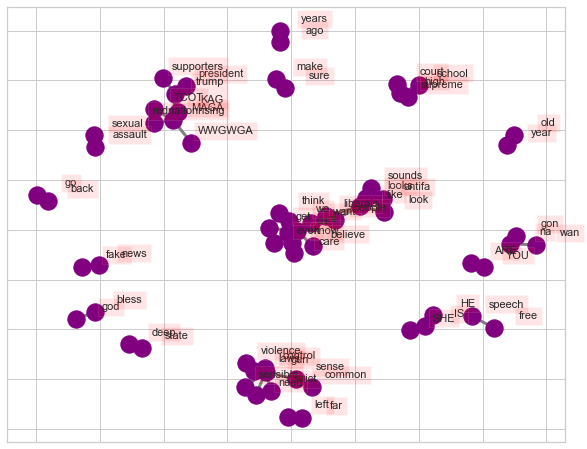

In [179]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

#G.add_node("china", weight=100)
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=1)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.10),
            horizontalalignment='center', fontsize=11)
    
plt.show()


This plot displays the networks of co-occurring words in tweets.

#### 3.11 Build a Matrix for Gephi Network Plot

It takes long time to run on the local disk, since it needs to loop through each word in each tweet to create a co_occurence matrix. I only tried out the sample here. Below is the code for getting a matrix for Gephi input.

In [180]:
# reference: https://pythondata.com/text-analytics-visualization/
keywords_array=[]
for index, row in df.iterrows():
    keywords=row['clean_Tweet'].split(' ')
    for kw in keywords:
        keywords_array.append((kw.strip(' '), row['clean_Tweet']))
kw_df = pd.DataFrame(keywords_array).rename(columns={0:'keyword', 1:'keywords'})
kw_df.head()

,keyword,keywords
0,,ask native americans take
1,ask,ask native americans take
2,native,ask native americans take
3,americans,ask native americans take
4,take,ask native americans take


In [181]:
len(kw_df)

149506

In [182]:
#just for the test, I sliced the dataframe.
kw_df_sample = kw_df[:1000]

In [183]:
from collections import OrderedDict

In [185]:
document = kw_df_sample.keywords.tolist()
names = kw_df_sample.keyword.tolist()
 
document_array = []
for item in document:
    items = item.split(',')
    document_array.append((items))
 
occurrences = OrderedDict((name, OrderedDict((name, 0) for name in names)) for name in names)
 
# Find the co-occurrences:
for l in document_array:
    for i in range(len(l)):
        for item in l[:i] + l[i + 1:]:
            occurrences[l[i]][item] += 1
 
co_occur = pd.DataFrame.from_dict(occurrences )

In [186]:
co_occur.head()

,,ask,native,americans,take,go,home,drunk,MAGA,trump,...,OMG,HE,EXTRA,ILY,call,NARCISSISTIC,SOCIOPATH,unfortunately,america,called
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ask,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
native,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
americans,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
take,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [206]:
co_occur.shape

(687, 687)

In [232]:
co_occur.to_csv('row687_gephi.csv')

#### Hope it is helpful!